In [15]:
import tensorflow as tf
from py_src.net import get_model
import numpy as np
from scipy.signal import convolve2d
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [16]:
IN_CHANNELS = 3
L1_OUT_CHANNELS = 4
L2_OUT_CHANNELS = 8
IN_WIDTH = 256
IN_HEIGHT = 256
L1_WIDTH = IN_WIDTH // 2
L1_HEIGHT = (IN_HEIGHT - 2) // 2
L2_WIDTH = L1_WIDTH // 2
L2_HEIGHT = (L1_HEIGHT - 2) // 2
L3_OUTPUT_SIZE = 16
ZERO_POINT_SHIFT = (1 / 256)
PRINT = False
KERNEL_SIZE = 3

train_dir = "./dataset/cats_and_dogs_256x256/train/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IN_WIDTH, IN_HEIGHT),
    batch_size=1,
    class_mode='binary',
)

model = get_model()
model.load_weights("./model/cats_dogs_net.h5")

l1_kernels = model.layers[1].get_weights()[0]
l2_kernels = model.layers[4].get_weights()[0]
l3_weights = model.layers[7].get_weights()[0]
l4_weights = model.layers[8].get_weights()[0]

l1_max = np.max(np.abs(l1_kernels))
l2_max = np.max(np.abs(l2_kernels))
l3_max = np.max(np.abs(l3_weights))
l4_max = np.max(np.abs(l4_weights))

l1_quantized = l1_kernels / l1_max * 127
l2_quantized = l2_kernels / l2_max * 127
l3_quantized = l3_weights / l3_max * 127
l4_quantized = l4_weights / l4_max * 127

l1_kernels = l1_quantized.reshape(KERNEL_SIZE * KERNEL_SIZE, -1).T.astype(np.int8)
l2_kernels = l2_quantized.reshape(KERNEL_SIZE * KERNEL_SIZE, -1).T.astype(np.int8)
l3_weights = l3_quantized.astype(np.int8)
l4_weights = l4_quantized.astype(np.int8)

kernel_groups_l1 = [[None] * IN_CHANNELS for _ in range(L1_OUT_CHANNELS)]
channels = []
for i in range(L1_OUT_CHANNELS):
    # separate the convolution filters for each color channel
    channels.append(l1_kernels[i::L1_OUT_CHANNELS])

for i, group in enumerate(channels):
    for j, kernel in enumerate(group):
        kernel_groups_l1[i][j] = kernel.reshape(3, 3)
        # flip the kernels to be able to use scipy 2D convolution and to get the correct results
        kernel_groups_l1[i][j] = np.flip(kernel_groups_l1[i][j], 0)
        kernel_groups_l1[i][j] = np.flip(kernel_groups_l1[i][j], 1)

l1_kernels = np.array(kernel_groups_l1).astype(np.int8)

kernel_groups_l2 = [[None] * L1_OUT_CHANNELS for _ in range(L2_OUT_CHANNELS)]
channels = []
for i in range(L2_OUT_CHANNELS):
    # separate the convolution filters for each color channel
    channels.append(l2_kernels[i::L2_OUT_CHANNELS])

for i, group in enumerate(channels):
    for j, kernel in enumerate(group):
        kernel_groups_l2[i][j] = kernel.reshape(3, 3)
        # flip the kernels to be able to use scipy 2D convolution and to get the correct results
        kernel_groups_l2[i][j] = np.flip(kernel_groups_l2[i][j], 0)
        kernel_groups_l2[i][j] = np.flip(kernel_groups_l2[i][j], 1)

l2_kernels = np.array(kernel_groups_l2).astype(np.int8)

Found 9892 images belonging to 2 classes.


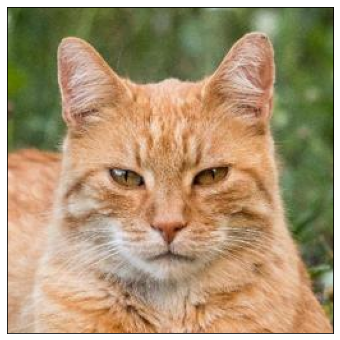

Image 1 of 10
Predicted: CAT,	 Expected: CAT
FPS: 18.462257236320298


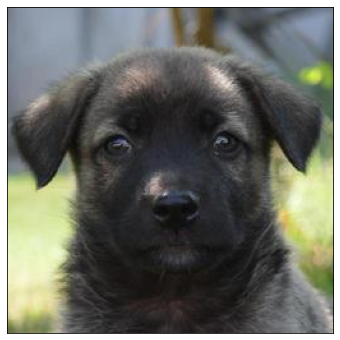

Image 2 of 10
Predicted: DOG,	 Expected: DOG
FPS: 17.95411630328776


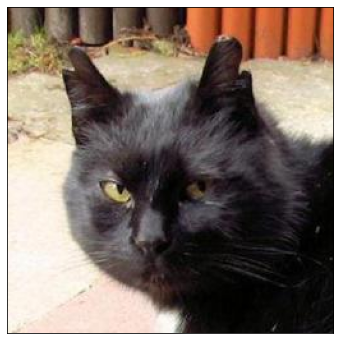

Image 3 of 10
Predicted: CAT,	 Expected: CAT
FPS: 18.76267871117938


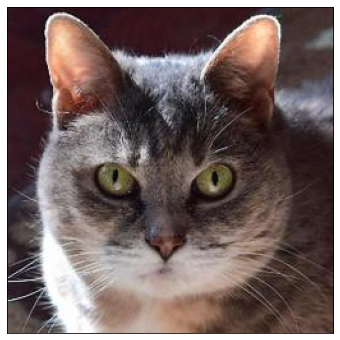

Image 4 of 10
Predicted: CAT,	 Expected: CAT
FPS: 18.620052384523902


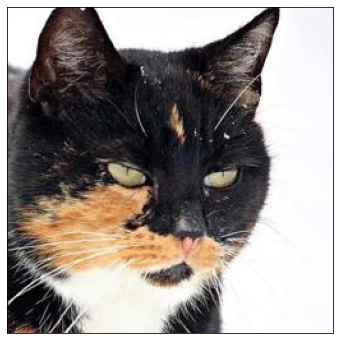

Image 5 of 10
Predicted: CAT,	 Expected: CAT
FPS: 18.58657831261233


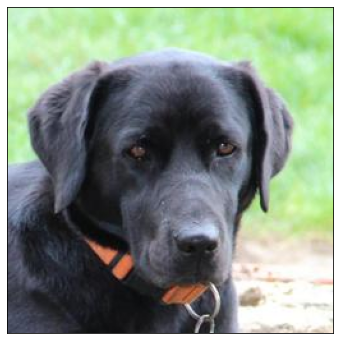

Image 6 of 10
Predicted: DOG,	 Expected: DOG
FPS: 18.596536720165812


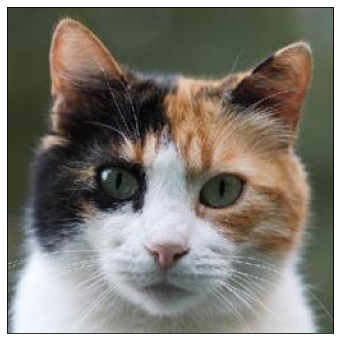

Image 7 of 10
Predicted: CAT,	 Expected: CAT
FPS: 17.34955296731609


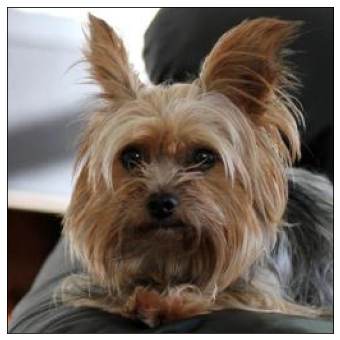

Image 8 of 10
Predicted: DOG,	 Expected: DOG
FPS: 18.169913339197596


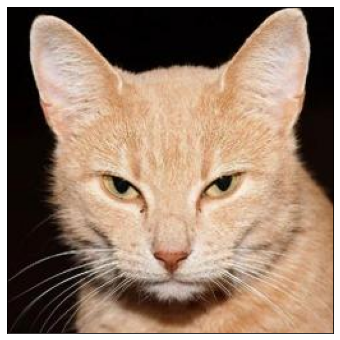

Image 9 of 10
Predicted: CAT,	 Expected: CAT
FPS: 18.233441108425644


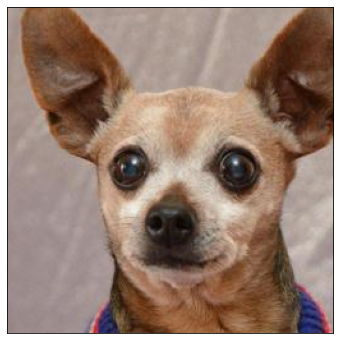

Image 10 of 10
Predicted: DOG,	 Expected: DOG
FPS: 17.43986717246813

Accuracy: 100.0 %


In [17]:
MAX_ITERATIONS = 10
CLEAR_OUTPUT = False # set to True for larger number of iterations
fig, ax = plt.subplots(figsize=(6, 6))
accuracy = 0
for n, (sample, expected_class) in zip(range(0, MAX_ITERATIONS), train_generator):
    ax.clear()
    ax.imshow(sample[0] * (1/255))
    ax.set_yticks([])
    ax.set_xticks([])
    if CLEAR_OUTPUT:
        clear_output(wait=True)
        display(fig)
    else:
        plt.show()
        fig, ax = plt.subplots(figsize=(6, 6))

    # reshape the samples to have 3 matrices of each color channel
    reshaped_sample = sample.reshape(IN_HEIGHT * IN_WIDTH, -1).T
    reshaped_sample = reshaped_sample.reshape(IN_CHANNELS, IN_HEIGHT, IN_WIDTH).astype(np.uint8)

    padded_sample = np.zeros((IN_CHANNELS, IN_HEIGHT, IN_WIDTH + 2)).astype(np.uint32)
    # add padding in the width dimension
    padded_sample[:, :, 1:-1] = reshaped_sample

    counter = 0
    start = time.time()
    while start + 2 > time.time():
        l1_outputs = []
        for i, group in enumerate(l1_kernels): # by each kernel in the first layer
            channel_sum = np.zeros((IN_HEIGHT - 2, IN_WIDTH), dtype=np.int32)
            for j, kernel in enumerate(group): # convolve each color channel with the kernel
                convolved = convolve2d(padded_sample[j], kernel, mode='valid')
                channel_sum += convolved       # cumulate the convolved channels

            output = np.maximum(channel_sum, 0)                    # ReLU activation
            output = block_reduce(output, (2, 2), np.max)          # max pooling
            output = (output * ZERO_POINT_SHIFT).astype(np.uint32) # shift the zero point
            l1_outputs.append(output)                              # save the final channel to the output of the layer
        
        l1_outputs = np.array(l1_outputs)
        padded_l1_outputs = np.zeros((L1_OUT_CHANNELS, L1_HEIGHT, L1_WIDTH + 2)).astype(np.uint32)
        padded_l1_outputs[:, :, 1:-1] = l1_outputs # add padding in the width dimension

        l2_outputs = []
        for i, group in enumerate(l2_kernels): # by each kernel in the second layer
            channel_sum = np.zeros((L1_HEIGHT - 2, L1_WIDTH), dtype=np.int32)
            for j, kernel in enumerate(group): # convolve each output channel of the first layer with the kernel
                convolved = convolve2d(padded_l1_outputs[j], kernel, mode='valid')
                channel_sum += convolved       # cumulate the convolved channels

            output = np.maximum(channel_sum, 0)                    # ReLU activation
            output = block_reduce(output, (2, 2), np.max)          # max pooling
            output = (output * ZERO_POINT_SHIFT).astype(np.uint32) # shift the zero point
            l2_outputs.append(output[:L2_HEIGHT, :L2_WIDTH])       # save the final channel to the output of the layer
        
        l2_outputs = np.array(l2_outputs)
        # flatten the output channels of the second layer to a single vector
        l2_outputs = l2_outputs.reshape(-1, L2_HEIGHT * L2_WIDTH).T
        l2_outputs = l2_outputs.flatten().reshape(1, -1)
        
        l3_outputs = np.dot(l2_outputs, l3_weights) # 1st fully connected layer (matrix multiplication)
        l3_outputs = np.maximum(l3_outputs, 0).astype(np.uint32)        # ReLU activation
        l3_outputs = (l3_outputs * ZERO_POINT_SHIFT).astype(np.uint32)  # shift the zero point

        l4_outputs = np.dot(l3_outputs, l4_weights) # 2nd fully connected layer (matrix multiplication)
        # the Sigmoid activation is not needed for the inference, simple comparison against 0 is enough
        counter += 1

    time_taken = time.time() - start
    
    predicted_class = "DOG" if l4_outputs[0, 0] >= 0 else "CAT"    # get the prediction
    expected_class = "DOG" if expected_class[0] >= 0.5 else "CAT"  # get the expected class 1 is DOG, 0 is CAT

    accuracy += predicted_class == expected_class
    print(f"Image {n + 1} of {MAX_ITERATIONS}")
    print(f"Predicted: {predicted_class},\t Expected: {expected_class}")
    print(f"FPS: {counter / time_taken}") # the last run of the inference was performed on: Intel(R) Core(TM) i5-4670K CPU @ 3.40GHz
    if CLEAR_OUTPUT:
        time.sleep(2) 


plt.clf()
plt.close()
print(f"\nAccuracy: {(accuracy / MAX_ITERATIONS) * 100} %")